In [1]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, classification_report,confusion_matrix, f1_score
import glob
import os
import matplotlib.pyplot as plt

In [2]:
# train_path = max(glob.glob('./data/twitter_data_train/*.csv'), key=os.path.getctime) 
# test_path = max(glob.glob('./data/test/*.csv'), key=os.path.getctime) 
train_df = pd.read_csv('./data/twitter_data_train_multiclass.csv')
test_df = pd.read_csv('./data/twitter_data_test_multiclass.csv')

print(train_df.shape)
print(test_df.shape)

(9446, 238)
(1667, 238)


In [3]:
to_drop = ['screen_name', 'url', 'profile_image_url', 'description',
           'id', 'name', 'account_type','account_type_multi', 'tweets_list', 'tweets_list_processed',
          'description_processed', 'protected', 'verified', 'Unnamed: 0']

X_train, y_train = train_df.drop(to_drop, axis=1), train_df['account_type_multi']
X_test, y_test = test_df.drop(to_drop, axis=1), test_df['account_type_multi']

In [4]:
# Combine train and test data set tgt
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [62]:
print(y.value_counts())

3    4372
1    3166
0    2751
4     367
2     360
5      97
Name: account_type_multi, dtype: int64


In [42]:
# Check if dataset is balanced
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9446, 225)
(9446,)
(1667, 225)
(1667,)


In [18]:
#Default model
model_xgboost_default = xgb.XGBClassifier(objective='multi:softprob')

model_xgboost_default.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=[(X_test, y_test)],
                  verbose=True)

xgb_train_default_predict = model_xgboost_default.predict(X_train)
xgb_test_default_predict = model_xgboost_default.predict(X_test)


c:\Users\bandy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.03169
[1]	validation_0-mlogloss:0.72049
[2]	validation_0-mlogloss:0.52947
[3]	validation_0-mlogloss:0.40074
[4]	validation_0-mlogloss:0.31082
[5]	validation_0-mlogloss:0.24521
[6]	validation_0-mlogloss:0.19777
[7]	validation_0-mlogloss:0.16437
[8]	validation_0-mlogloss:0.13782
[9]	validation_0-mlogloss:0.11822
[10]	validation_0-mlogloss:0.10315
[11]	validation_0-mlogloss:0.09264
[12]	validation_0-mlogloss:0.08477
[13]	validation_0-mlogloss:0.07841
[14]	validation_0-mlogloss:0.07344
[15]	validation_0-mlogloss:0.07026
[16]	validation_0-mlogloss:0.06815
[17]	validation_0-mlogloss:0.06641
[18]	validation_0-mlogloss:0.06446
[19]	validation_0-mlogloss:0.06261
[20]	validation_0-mlogloss:0.06153
[21]	validation_0-mlogloss:0.06073
[22]	validation_0-mlogloss:0.06036
[23]	validation_0-mlogloss:0.05983
[24]	validation_0-mlogloss:0.05989
[25]	validation_0-mlogloss:0.06007
[26]	validation_0-mlogloss:0.05988
[27]	validation_0-mlogloss:0.06004
[28]	validation_0-mlogloss:0.0

In [19]:
print(model_xgboost_default.get_params)

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)>


**Evaluate Model Performance**

In [20]:
print(confusion_matrix(y_train, xgb_train_default_predict))
print(classification_report(y_train, xgb_train_default_predict))

[[2338    0    0    0    0    0]
 [   0 2706    0    0    0    0]
 [   0    0  302    0    0    0]
 [   0    0    0 3706    0    0]
 [   0    0    0    0  314    0]
 [   0    0    0    0    0   80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2338
           1       1.00      1.00      1.00      2706
           2       1.00      1.00      1.00       302
           3       1.00      1.00      1.00      3706
           4       1.00      1.00      1.00       314
           5       1.00      1.00      1.00        80

    accuracy                           1.00      9446
   macro avg       1.00      1.00      1.00      9446
weighted avg       1.00      1.00      1.00      9446



In [21]:
print(confusion_matrix(y_test, xgb_test_default_predict))
print(classification_report(y_test, xgb_test_default_predict))

[[409   0   1   3   0   0]
 [  1 458   0   1   0   0]
 [  5   0  53   0   0   0]
 [ 11   0   0 655   0   0]
 [  1   0   0   0  52   0]
 [  1   0   0   0   0  16]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       413
           1       1.00      1.00      1.00       460
           2       0.98      0.91      0.95        58
           3       0.99      0.98      0.99       666
           4       1.00      0.98      0.99        53
           5       1.00      0.94      0.97        17

    accuracy                           0.99      1667
   macro avg       0.99      0.97      0.98      1667
weighted avg       0.99      0.99      0.99      1667



**Hyperparameter Tuning**

In [6]:
learning_rate_list = [0.1, 0.3, 0.5]
max_depth_list = [2, 3, 5]
n_estimators_list = [50, 100, 150]
subsample_list = [0.3, 0.5, 0.7]
colsample_bytree_list =  [0.3, 0.5, 0.7]


params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list,
               "subsample": subsample_list,
               "colsample_bytree" : colsample_bytree_list}

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict

243


{'learning_rate': [0.1, 0.3, 0.5],
 'max_depth': [2, 3, 5],
 'n_estimators': [50, 100, 150],
 'subsample': [0.3, 0.5, 0.7],
 'colsample_bytree': [0.3, 0.5, 0.7]}

In [7]:
# Custom cross-validation method
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=2022)

model_xgboost_tuning = RandomizedSearchCV(estimator=xgb.XGBClassifier(),
                                param_distributions = params_dict,
                                cv=cv_method,
                                scoring='f1_weighted',
                                n_iter = 100,
                                verbose=2,
                                random_state=2022)

model_xgboost_tuning.fit(X, y)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=  21.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   2.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   1.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   1.4s
[CV] END colsample_bytr

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=2022),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=No...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7],
                                        'learning_rate': [0.1, 0.3, 0.5],
                                        'max_depth': [2, 3, 5],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.3, 0.5, 0.7]},
                   random_state=2022, scoring='f1_weighted', verbose=2)

In [8]:
model_xgboost_tuning.best_params_

{'subsample': 0.7,
 'n_estimators': 150,
 'max_depth': 5,
 'learning_rate': 0.3,
 'colsample_bytree': 0.7}

In [10]:
results_df = pd.DataFrame(model_xgboost_tuning.cv_results_)
results_df = results_df[['rank_test_score','mean_test_score', 'param_subsample',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'param_colsample_bytree']]
results_df.sort_values(by='rank_test_score', inplace=True)
results_df[:10]

,rank_test_score,mean_test_score,param_subsample,param_learning_rate,param_max_depth,param_n_estimators,param_colsample_bytree
36,1,0.991975,0.7,0.3,5,150,0.7
40,2,0.991854,0.7,0.3,5,100,0.7
81,3,0.991590,0.5,0.1,5,150,0.3
5,4,0.991559,0.5,0.3,5,150,0.5
41,5,0.991557,0.5,0.5,5,50,0.7
2,6,0.991557,0.7,0.5,5,100,0.7
79,7,0.991556,0.7,0.1,5,150,0.7
57,8,0.991527,0.5,0.5,5,100,0.7
76,9,0.991467,0.3,0.1,5,150,0.5
35,10,0.991439,0.7,0.3,5,150,0.5


## Final Model
Using best parameters from above step

In [5]:
import time
from sklearn.metrics import f1_score

model_xgboost_fin = xgb.XGBClassifier(subsample = 0.7, n_estimators= 150, max_depth= 5, learning_rate= 0.3, colsample_bytree= 0.7)
start_time = time.time()

model_xgboost_fin.fit(X_train, y_train, verbose =True)
y_pred_test = model_xgboost_fin.predict(X_test)

time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds
print(confusion_matrix(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test, digits=5))
# roc_auc_score(y_test, y_pred_test)
f1_score(y_test, y_pred_test, average='weighted')

Total time taken for the program execution 18.373870849609375
[[411   0   1   1   0   0]
 [  1 458   0   1   0   0]
 [  5   0  53   0   0   0]
 [ 11   1   0 654   0   0]
 [  1   0   0   0  52   0]
 [  0   0   0   1   0  16]]
              precision    recall  f1-score   support

           0    0.95804   0.99516   0.97625       413
           1    0.99782   0.99565   0.99674       460
           2    0.98148   0.91379   0.94643        58
           3    0.99543   0.98198   0.98866       666
           4    1.00000   0.98113   0.99048        53
           5    1.00000   0.94118   0.96970        17

    accuracy                        0.98620      1667
   macro avg    0.98880   0.96815   0.97804      1667
weighted avg    0.98654   0.98620   0.98621      1667



0.9862089471258709

In [6]:
var_colums = [c for c in X_train.columns if c not in ['state']]

df_var_imp = pd.DataFrame({"Feature": var_colums,
                           "Importance": model_xgboost_fin.feature_importances_})\
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:10]

,Feature,Importance
53,tweets_31,0.336415
150,description_28,0.129658
180,description_58,0.044110
78,tweets_56,0.041472
5,default_profile,0.034580
168,description_46,0.032376
59,tweets_37,0.026674
3,favourites_count,0.025855
45,tweets_23,0.024096
41,tweets_19,0.023746


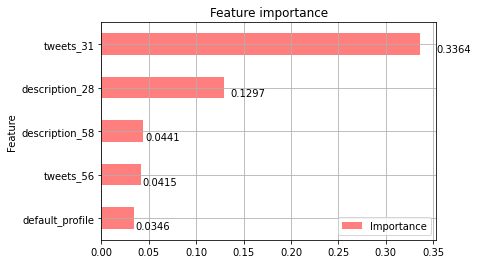

In [7]:
top_5_features = df_var_imp[:5].sort_values('Importance').set_index('Feature')
ax = top_5_features.plot.barh(color='red', alpha=0.5, grid=True, title='Feature importance', figsize=(6, 4))
for p, value in zip(ax.patches, top_5_features['Importance']):
    ax.annotate(round(value, 4), (p.get_width() * 1.05, p.get_y() * 1.02))

                                  Importance
Token                                       
default_profile                     0.034580
tweets_56: "need"                   0.041472
description_58: "member"            0.044110
description_28: "follow account"    0.129658
tweets_31: "great introduction"     0.336415


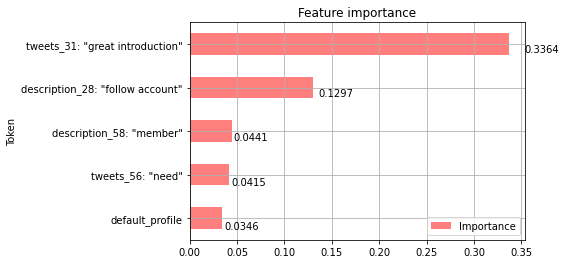

In [13]:
top_5_features['Token'] = ['default_profile', 'tweets_56: "need"', 'description_58: "member"', 'description_28: "follow account"', 'tweets_31: "great introduction"']
top_5_features = top_5_features.set_index('Token')
print(top_5_features)
ax = top_5_features.plot.barh(color='red', alpha=0.5, grid=True, title='Feature importance', figsize=(6, 4))
for p, value in zip(ax.patches, top_5_features['Importance']):
    ax.annotate(round(value, 4), (p.get_width() * 1.05, p.get_y() * 1.02))

In [9]:
import pickle
with open('./data/tfidf_feature_names.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [10]:
print(loaded_dict)

{'tweets': [(0, 'al'), (1, 'always'), (2, 'amp'), (3, 'anche'), (4, 'back'), (5, 'best'), (6, 'cant'), (7, 'che'), (8, 'check'), (9, 'chi'), (10, 'ci'), (11, 'come'), (12, 'con'), (13, 'cool'), (14, 'da'), (15, 'day'), (16, 'de'), (17, 'dei'), (18, 'del'), (19, 'della'), (20, 'di'), (21, 'dont'), (22, 'e'), (23, 'essere'), (24, 'get'), (25, 'gli'), (26, 'go'), (27, 'going'), (28, 'good'), (29, 'got'), (30, 'great'), (31, 'great introduction'), (32, 'ha'), (33, 'history'), (34, 'ho'), (35, 'il'), (36, 'im'), (37, 'introduction'), (38, 'io'), (39, 'know'), (40, 'la'), (41, 'le'), (42, 'learn'), (43, 'life'), (44, 'like'), (45, 'lo'), (46, 'lol'), (47, 'look'), (48, 'love'), (49, 'mai'), (50, 'make'), (51, 'man'), (52, 'mi'), (53, 'money'), (54, 'much'), (55, 'na'), (56, 'need'), (57, 'never'), (58, 'new'), (59, 'non'), (60, 'one'), (61, 'people'), (62, 'per'), (63, 'perch'), (64, 'pi'), (65, 'quando'), (66, 'read'), (67, 'read history'), (68, 'really'), (69, 'right'), (70, 'say'), (71, '